## Setup YOLO and Data For Training

In [ ]:
# ! unzip -qq YOLOX.zip
# ! unzip -qq character-detection-datasets.zip

%cd YOLOX

! pip install ninja
! pip install numpy
! pip install opencv_python
! pip install loguru
! pip install tqdm
! pip install thop
! pip install tabulate
! pip install psutil
! pip install tensorboard
! pip install pycocotools
! python setup.py build develop

/scrfs/storage/sunandad/home/Downloads/HW2/HW2/code/YOLOX
/home/sunandad/.conda/envs/deeplearning/lib/python3.12/site-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running build
running build_py
running egg_info
writing yolox.egg-info/PKG-INFO
writing dependency_links to yolox.egg-info/dependency_links.txt
writing top-level names to yolox.egg-info/top_level.txt
reading manifest file 'yolox.egg-info/SOURCES.txt'
writing manifest file 'yolox.egg-info/SOURCES.txt'
/home/sunandad/.conda/envs/deeplearning/lib/python3.12/site-packages/setuptools/command/build_py.p

## Import Libraries for Training and Testing

In [ ]:
import os
from dataclasses import dataclass

from yolox.exp import Exp as MyExp


import argparse
import random
import warnings
from loguru import logger

import torch
import torch.backends.cudnn as cudnn

from yolox.exp import Exp, check_exp_value, get_exp
from yolox.utils import configure_module, configure_nccl, configure_omp, get_num_devices

from yolox.data.data_augment import ValTransform
import cv2
from yolox.utils import postprocess, vis
import time

import matplotlib.pyplot as plt
from torch.optim import Adam

## Define Model and Training Config

In [ ]:
class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 0.33
        self.width = 0.50
        self.exp_name = "Character-Detection"

        self.data_dir = "/home/sunandad/Downloads/HW2/HW2/code/character-detection-datasets"
        self.train_ann = "train.json"
        self.val_ann = "test.json"
        self.num_classes = 36
        self.max_epoch = 200
        self.eval_interval = 1
        self.data_num_workers = 4

        # Data augmentation settings
        self.enable_mosaic = True
        self.enable_mixup = True
        self.mosaic_prob = 0.5
        self.mixup_prob = 0.5
        self.degrees = 10.0
        self.translate = 0.1
        self.scale = (0.5, 1.5)
        self.shear = 2.0

        # Learning rate settings
        self.basic_lr_per_img = 0.01 / 64.0
        self.warmup_epochs = 5
        self.min_lr_ratio = 0.05
        self.no_aug_epochs = 15
        self.optimizer_type = "adam"
        self.optimizer = None  # Initialize optimizer as None

    def get_optimizer(self, batch_size):
        # Use Adam optimizer
        self.optimizer = Adam(self.model.parameters(), lr=self.basic_lr_per_img * batch_size)
        return self.optimizer

@dataclass
class TrainingConfig:
    experiment_name: str = "CharacterDetection"
    batch_size: int = 16
    resume: bool = False
    ckpt: str = None
    start_epoch: int = 1
    num_machines: int = 1
    machine_rank: int = 0
    fp16: bool = False
    occupy: bool = False
    logger: str = 'tensorboard'
    output_dir = 'checkpoints/'
    cache: str = None

## Load Model and Train

In [ ]:
args = TrainingConfig()
exp = Exp()
trainer = exp.get_trainer(args)
trainer.train()

2025-02-13 22:08:02.389897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739506082.401664   12783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739506082.405228   12783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 22:08:02.419221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/scrfs/storage/sunandad/home/Downloads/HW2/HW2/code/YOLOX/yolox/core/trainer.py:47: FutureWarning: `torch.cuda.amp.GradScaler

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2025-02-13 22:08:05 | INFO     | yolox.core.trainer:157 - init prefetcher, this might take one minute or less...


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2025-02-13 22:08:05 | INFO     | yolox.core.trainer:196 - Training start...
2025-02-13 22:08:05 | INFO     | yolox.core.trainer:197 - 
YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.71 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.15 seconds.


2025-02-13 22:08:47 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.09 ms, Average NMS time: 0.56 ms, Average inference time: 1.65 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=6.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 9.07 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.18 seconds.


2025-02-13 22:10:46 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.48 ms, Average NMS time: 4.60 ms, Average inference time: 6.07 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:11:08 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.13 seconds.


2025-02-13 22:11:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:11:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch5
2025-02-13 22:11:10 | INFO     | yolox.core.trainer:270 - epoch: 5/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 7.3, iou_loss: 2.5, l1_loss: 0.0, conf_loss: 3.1, cls_loss: 1.7, lr: 1.663e-03, size: 768, ETA: 0:56:49
2025-02-13 22:11:11 | INFO     | yolox.core.trainer:270 - epoch: 5/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 6.2, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 2.5, cls_loss: 1.4, lr: 1.726e-03, size: 640, ETA: 0:56:51
2025-02-13 22:11:13 | INFO     | yolox.core.trainer:270 - epoch: 5/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.1Gb, iter_time: 0.132s, data_time: 0.001s, total_loss: 6.4, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 2.5, cls_loss: 1.5, lr: 1.791e-03, size: 672, ETA: 0:56:48

Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:11:29 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.29 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-13 22:11:29 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:11:29 | INFO     | yolox.core.trainer:218 - ---> start train epoch6
2025-02-13 22:11:31 | INFO     | yolox.core.trainer:270 - epoch: 6/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.136s, data_time: 0.001s, total_loss: 6.0, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 2.2, cls_loss: 1.5, lr: 2.500e-03, size: 800, ETA: 0:56:28
2025-02-13 22:11:32 | INFO     | yolox.core.trainer:270 - epoch: 6/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 6.5, iou_loss: 2.6, l1_loss: 0.0, conf_loss: 2.5, cls_loss: 1.4, lr: 2.500e-03, size: 512, ETA: 0:56:29
2025-02-13 22:11:33 | INFO     | yolox.core.trainer:270 - epoch: 6/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.1Gb, iter_time: 0.131s, data_time: 0.001s, total_loss: 6.2, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 2.4, cls_loss: 1.5, lr: 2.500e-03, size: 768, ETA: 0:56:26

Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:11:47 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.799
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-13 22:11:48 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:11:48 | INFO     | yolox.core.trainer:218 - ---> start train epoch7
2025-02-13 22:11:49 | INFO     | yolox.core.trainer:270 - epoch: 7/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 4.7, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.2, lr: 2.500e-03, size: 480, ETA: 0:55:13
2025-02-13 22:11:50 | INFO     | yolox.core.trainer:270 - epoch: 7/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.113s, data_time: 0.001s, total_loss: 5.1, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.9, cls_loss: 1.2, lr: 2.500e-03, size: 704, ETA: 0:55:06
2025-02-13 22:11:52 | INFO     | yolox.core.trainer:270 - epoch: 7/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.156s, data_time: 0.001s, total_loss: 5.2, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 2.0, cls_loss: 1.2, lr: 2.500e-03, size: 768, ETA: 0:55:12

Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:12:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.53 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-13 22:12:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:12:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch8
2025-02-13 22:12:09 | INFO     | yolox.core.trainer:270 - epoch: 8/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.134s, data_time: 0.001s, total_loss: 4.8, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.1, lr: 2.499e-03, size: 576, ETA: 0:55:08
2025-02-13 22:12:10 | INFO     | yolox.core.trainer:270 - epoch: 8/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 5.6, iou_loss: 2.4, l1_loss: 0.0, conf_loss: 2.2, cls_loss: 1.1, lr: 2.499e-03, size: 736, ETA: 0:55:05
2025-02-13 22:12:12 | INFO     | yolox.core.trainer:270 - epoch: 8/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.162s, data_time: 0.001s, total_loss: 5.1, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 1.7, cls_loss: 1.2, lr: 2.499e-03, size: 736, ETA: 0:55:12

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.17 seconds.
Accumulating evaluation results...


2025-02-13 22:12:25 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.927
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:12:26 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:12:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch9
2025-02-13 22:12:28 | INFO     | yolox.core.trainer:270 - epoch: 9/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.1Gb, iter_time: 0.160s, data_time: 0.001s, total_loss: 5.4, iou_loss: 2.2, l1_loss: 0.0, conf_loss: 2.0, cls_loss: 1.2, lr: 2.498e-03, size: 480, ETA: 0:54:22
2025-02-13 22:12:29 | INFO     | yolox.core.trainer:270 - epoch: 9/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.110s, data_time: 0.001s, total_loss: 6.9, iou_loss: 2.8, l1_loss: 0.0, conf_loss: 2.6, cls_loss: 1.6, lr: 2.498e-03, size: 768, ETA: 0:54:16
2025-02-13 22:12:30 | INFO     | yolox.core.trainer:270 - epoch: 9/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.172s, data_time: 0.001s, total_loss: 4.6, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.1, lr: 2.498e-03, size: 768, ETA: 0:54:24

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.17 seconds.
Accumulating evaluation results...


2025-02-13 22:12:45 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:12:46 | INFO     | yolox.core.trainer:218 - ---> start train epoch10
2025-02-13 22:12:47 | INFO     | yolox.core.trainer:270 - epoch: 10/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 4.3, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 0.9, lr: 2.497e-03, size: 768, ETA: 0:54:09
2025-02-13 22:12:49 | INFO     | yolox.core.trainer:270 - epoch: 10/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.165s, data_time: 0.001s, total_loss: 4.4, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 1.0, lr: 2.497e-03, size: 640, ETA: 0:54:15
2025-02-13 22:12:50 | INFO     | yolox.core.trainer:270 - epoch: 10/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.123s, data_time: 0.001s, total_loss: 4.0, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 0.7, lr: 2.497e-03, size: 512, ETA: 0:54:12
2025-02-13 22:12:51 | INFO     | yolox.core.trainer:270 - epoch: 10/200, iter: 40/129, gpu mem: 9500Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.14 seconds.
Accumulating evaluation results...


2025-02-13 22:13:04 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.603
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:13:04 | INFO     | yolox.core.trainer:218 - ---> start train epoch11
2025-02-13 22:13:05 | INFO     | yolox.core.trainer:270 - epoch: 11/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.110s, data_time: 0.001s, total_loss: 4.6, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.2, lr: 2.495e-03, size: 544, ETA: 0:53:30
2025-02-13 22:13:06 | INFO     | yolox.core.trainer:270 - epoch: 11/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 2.495e-03, size: 672, ETA: 0:53:30
2025-02-13 22:13:07 | INFO     | yolox.core.trainer:270 - epoch: 11/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.106s, data_time: 0.001s, total_loss: 4.4, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 0.9, lr: 2.495e-03, size: 544, ETA: 0:53:24
2025-02-13 22:13:09 | INFO     | yolox.core.trainer:270 - epoch: 11/200, iter: 40/129, gpu mem: 9500Mb, 

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:13:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:13:22 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:13:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch12
2025-02-13 22:13:23 | INFO     | yolox.core.trainer:270 - epoch: 12/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.100s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.6, lr: 2.493e-03, size: 512, ETA: 0:52:52
2025-02-13 22:13:24 | INFO     | yolox.core.trainer:270 - epoch: 12/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.121s, data_time: 0.001s, total_loss: 4.2, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.0, lr: 2.493e-03, size: 608, ETA: 0:52:50
2025-02-13 22:13:26 | INFO     | yolox.core.trainer:270 - epoch: 12/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.162s, data_time: 0.001s, total_loss: 4.0, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.1, lr: 2.493e-03, size: 768, ETA: 0:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.14 seconds.
Accumulating evaluation results...


2025-02-13 22:13:41 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.48 ms, Average inference time: 1.53 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:13:42 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:13:42 | INFO     | yolox.core.trainer:218 - ---> start train epoch13
2025-02-13 22:13:43 | INFO     | yolox.core.trainer:270 - epoch: 13/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 4.7, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 1.1, lr: 2.491e-03, size: 640, ETA: 0:52:49
2025-02-13 22:13:45 | INFO     | yolox.core.trainer:270 - epoch: 13/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 3.8, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 2.491e-03, size: 672, ETA: 0:52:49
2025-02-13 22:13:46 | INFO     | yolox.core.trainer:270 - epoch: 13/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 2.491e-03, size: 544, ETA: 0:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:14:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:14:01 | INFO     | yolox.core.trainer:218 - ---> start train epoch14
2025-02-13 22:14:03 | INFO     | yolox.core.trainer:270 - epoch: 14/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.152s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.7, lr: 2.488e-03, size: 704, ETA: 0:52:42
2025-02-13 22:14:04 | INFO     | yolox.core.trainer:270 - epoch: 14/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.136s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 2.488e-03, size: 640, ETA: 0:52:42
2025-02-13 22:14:05 | INFO     | yolox.core.trainer:270 - epoch: 14/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 4.5, iou_loss: 2.2, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.0, lr: 2.488e-03, size: 480, ETA: 0:52:36
2025-02-13 22:14:06 | INFO     | yolox.core.trainer:270 - epoch: 14/200, iter: 40/129, gpu mem: 9500Mb, 

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:14:20 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:14:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:14:21 | INFO     | yolox.core.trainer:218 - ---> start train epoch15
2025-02-13 22:14:22 | INFO     | yolox.core.trainer:270 - epoch: 15/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.144s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.7, lr: 2.485e-03, size: 736, ETA: 0:52:26
2025-02-13 22:14:24 | INFO     | yolox.core.trainer:270 - epoch: 15/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.154s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.7, lr: 2.485e-03, size: 736, ETA: 0:52:28
2025-02-13 22:14:25 | INFO     | yolox.core.trainer:270 - epoch: 15/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 3.6, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 2.485e-03, size: 544, ETA: 0:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.14 seconds.
Accumulating evaluation results...


2025-02-13 22:14:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.589
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:14:40 | INFO     | yolox.core.trainer:218 - ---> start train epoch16
2025-02-13 22:14:41 | INFO     | yolox.core.trainer:270 - epoch: 16/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 2.482e-03, size: 480, ETA: 0:52:11
2025-02-13 22:14:43 | INFO     | yolox.core.trainer:270 - epoch: 16/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 4.1, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.0, lr: 2.481e-03, size: 704, ETA: 0:52:08
2025-02-13 22:14:44 | INFO     | yolox.core.trainer:270 - epoch: 16/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.6, lr: 2.481e-03, size: 608, ETA: 0:52:07
2025-02-13 22:14:45 | INFO     | yolox.core.trainer:270 - epoch: 16/200, iter: 40/129, gpu mem: 9500Mb, 

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:14:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.854
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.703
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:14:57 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:14:57 | INFO     | yolox.core.trainer:218 - ---> start train epoch17
2025-02-13 22:14:58 | INFO     | yolox.core.trainer:270 - epoch: 17/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.123s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 2.478e-03, size: 736, ETA: 0:51:26
2025-02-13 22:15:00 | INFO     | yolox.core.trainer:270 - epoch: 17/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.165s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 2.478e-03, size: 768, ETA: 0:51:29
2025-02-13 22:15:02 | INFO     | yolox.core.trainer:270 - epoch: 17/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.162s, data_time: 0.001s, total_loss: 3.5, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 2.477e-03, size: 768, ETA: 0:5

Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:15:17 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-13 22:15:17 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:15:17 | INFO     | yolox.core.trainer:218 - ---> start train epoch18
2025-02-13 22:15:18 | INFO     | yolox.core.trainer:270 - epoch: 18/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.474e-03, size: 480, ETA: 0:51:10
2025-02-13 22:15:19 | INFO     | yolox.core.trainer:270 - epoch: 18/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.092s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 2.473e-03, size: 512, ETA: 0:51:04
2025-02-13 22:15:20 | INFO     | yolox.core.trainer:270 - epoch: 18/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.2Gb, iter_time: 0.097s, data_time: 0.001s, total_loss: 3.6, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.473e-03, size: 576, ETA: 0:5

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:15:35 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:15:35 | INFO     | yolox.core.trainer:218 - ---> start train epoch19
2025-02-13 22:15:37 | INFO     | yolox.core.trainer:270 - epoch: 19/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.148s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 2.469e-03, size: 800, ETA: 0:50:51
2025-02-13 22:15:38 | INFO     | yolox.core.trainer:270 - epoch: 19/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.169s, data_time: 0.001s, total_loss: 3.9, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 2.469e-03, size: 608, ETA: 0:50:53
2025-02-13 22:15:40 | INFO     | yolox.core.trainer:270 - epoch: 19/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.114s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.468e-03, size: 480, ETA: 0:50:50
2025-02-13 22:15:41 | INFO     | yolox.core.trainer:270 - epoch: 19/200, iter: 40/129, gpu mem: 9500Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.14 seconds.
Accumulating evaluation results...


2025-02-13 22:15:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.965
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:15:56 | INFO     | yolox.core.trainer:218 - ---> start train epoch20
2025-02-13 22:15:57 | INFO     | yolox.core.trainer:270 - epoch: 20/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.141s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.7, lr: 2.464e-03, size: 608, ETA: 0:50:46
2025-02-13 22:15:58 | INFO     | yolox.core.trainer:270 - epoch: 20/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.122s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 2.464e-03, size: 576, ETA: 0:50:44
2025-02-13 22:15:59 | INFO     | yolox.core.trainer:270 - epoch: 20/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.121s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.464e-03, size: 800, ETA: 0:50:42
2025-02-13 22:16:01 | INFO     | yolox.core.trainer:270 - epoch: 20/200, iter: 40/129, gpu mem: 9500Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.14 seconds.
Accumulating evaluation results...


2025-02-13 22:16:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.685
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:16:15 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:16:15 | INFO     | yolox.core.trainer:218 - ---> start train epoch21
2025-02-13 22:16:16 | INFO     | yolox.core.trainer:270 - epoch: 21/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.140s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 2.459e-03, size: 704, ETA: 0:50:31
2025-02-13 22:16:17 | INFO     | yolox.core.trainer:270 - epoch: 21/200, iter: 20/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.093s, data_time: 0.001s, total_loss: 3.6, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 1.0, lr: 2.459e-03, size: 480, ETA: 0:50:27
2025-02-13 22:16:18 | INFO     | yolox.core.trainer:270 - epoch: 21/200, iter: 30/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.458e-03, size: 544, ETA: 0:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:16:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:16:34 | INFO     | yolox.core.trainer:218 - ---> start train epoch22
2025-02-13 22:16:35 | INFO     | yolox.core.trainer:270 - epoch: 22/200, iter: 10/129, gpu mem: 9500Mb, mem: 35.3Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 2.454e-03, size: 480, ETA: 0:50:07
2025-02-13 22:16:36 | INFO     | yolox.core.trainer:270 - epoch: 22/200, iter: 20/129, gpu mem: 9502Mb, mem: 35.3Gb, iter_time: 0.169s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 2.453e-03, size: 800, ETA: 0:50:09
2025-02-13 22:16:38 | INFO     | yolox.core.trainer:270 - epoch: 22/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.132s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.453e-03, size: 640, ETA: 0:50:08
2025-02-13 22:16:39 | INFO     | yolox.core.trainer:270 - epoch: 22/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:16:54 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.664
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.830
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:16:54 | INFO     | yolox.core.trainer:218 - ---> start train epoch23
2025-02-13 22:16:56 | INFO     | yolox.core.trainer:270 - epoch: 23/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.2Gb, iter_time: 0.160s, data_time: 0.001s, total_loss: 3.7, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 1.0, lr: 2.448e-03, size: 768, ETA: 0:50:09
2025-02-13 22:16:57 | INFO     | yolox.core.trainer:270 - epoch: 23/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.447e-03, size: 480, ETA: 0:50:05
2025-02-13 22:16:58 | INFO     | yolox.core.trainer:270 - epoch: 23/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.154s, data_time: 0.001s, total_loss: 4.1, iou_loss: 2.2, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 2.447e-03, size: 768, ETA: 0:50:06
2025-02-13 22:17:00 | INFO     | yolox.core.trainer:270 - epoch: 23/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.15 seconds.
Accumulating evaluation results...


2025-02-13 22:17:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:17:14 | INFO     | yolox.core.trainer:218 - ---> start train epoch24
2025-02-13 22:17:15 | INFO     | yolox.core.trainer:270 - epoch: 24/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.117s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.441e-03, size: 640, ETA: 0:49:53
2025-02-13 22:17:16 | INFO     | yolox.core.trainer:270 - epoch: 24/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.2Gb, iter_time: 0.115s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 2.441e-03, size: 544, ETA: 0:49:50
2025-02-13 22:17:17 | INFO     | yolox.core.trainer:270 - epoch: 24/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.2Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 3.6, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 2.440e-03, size: 608, ETA: 0:49:48
2025-02-13 22:17:19 | INFO     | yolox.core.trainer:270 - epoch: 24/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:17:34 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.724
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.911
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:17:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.655
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:17:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch26
2025-02-13 22:17:57 | INFO     | yolox.core.trainer:270 - epoch: 26/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.177s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.428e-03, size: 768, ETA: 0:49:41
2025-02-13 22:17:58 | INFO     | yolox.core.trainer:270 - epoch: 26/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.159s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.427e-03, size: 704, ETA: 0:49:42
2025-02-13 22:18:00 | INFO     | yolox.core.trainer:270 - epoch: 26/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.2Gb, iter_time: 0.146s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.427e-03, size: 672, ETA: 0:49:42
2025-02-13 22:18:01 | INFO     | yolox.core.trainer:270 - epoch: 26/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:18:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.665
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.16 seconds.
Accumulating evaluation results...


2025-02-13 22:18:36 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:18:36 | INFO     | yolox.core.trainer:218 - ---> start train epoch28
2025-02-13 22:18:37 | INFO     | yolox.core.trainer:270 - epoch: 28/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.149s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 2.413e-03, size: 640, ETA: 0:49:23
2025-02-13 22:18:39 | INFO     | yolox.core.trainer:270 - epoch: 28/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.127s, data_time: 0.001s, total_loss: 3.5, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 2.412e-03, size: 640, ETA: 0:49:21
2025-02-13 22:18:40 | INFO     | yolox.core.trainer:270 - epoch: 28/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 1.0, lr: 2.412e-03, size: 576, ETA: 0:49:19
2025-02-13 22:18:41 | INFO     | yolox.core.trainer:270 - epoch: 28/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:18:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:18:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch29
2025-02-13 22:18:56 | INFO     | yolox.core.trainer:270 - epoch: 29/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.131s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.405e-03, size: 608, ETA: 0:49:03
2025-02-13 22:18:58 | INFO     | yolox.core.trainer:270 - epoch: 29/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.123s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 2.404e-03, size: 576, ETA: 0:49:01
2025-02-13 22:18:59 | INFO     | yolox.core.trainer:270 - epoch: 29/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.127s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 2.404e-03, size: 800, ETA: 0:48:59
2025-02-13 22:19:01 | INFO     | yolox.core.trainer:270 - epoch: 29/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:19:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.728
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.911
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.721
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:19:15 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:19:15 | INFO     | yolox.core.trainer:218 - ---> start train epoch30
2025-02-13 22:19:16 | INFO     | yolox.core.trainer:270 - epoch: 30/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.149s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.397e-03, size: 576, ETA: 0:48:49
2025-02-13 22:19:17 | INFO     | yolox.core.trainer:270 - epoch: 30/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 3.8, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 2.396e-03, size: 544, ETA: 0:48:46
2025-02-13 22:19:18 | INFO     | yolox.core.trainer:270 - epoch: 30/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 2.395e-03, size: 640, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:19:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.698
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:19:33 | INFO     | yolox.core.trainer:218 - ---> start train epoch31
2025-02-13 22:19:35 | INFO     | yolox.core.trainer:270 - epoch: 31/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.134s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.388e-03, size: 672, ETA: 0:48:28
2025-02-13 22:19:36 | INFO     | yolox.core.trainer:270 - epoch: 31/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.387e-03, size: 544, ETA: 0:48:25
2025-02-13 22:19:38 | INFO     | yolox.core.trainer:270 - epoch: 31/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.176s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.387e-03, size: 800, ETA: 0:48:26
2025-02-13 22:19:39 | INFO     | yolox.core.trainer:270 - epoch: 31/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:19:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.48 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.981
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.721
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:19:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch32
2025-02-13 22:19:52 | INFO     | yolox.core.trainer:270 - epoch: 32/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.123s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.379e-03, size: 640, ETA: 0:48:01
2025-02-13 22:19:53 | INFO     | yolox.core.trainer:270 - epoch: 32/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.378e-03, size: 576, ETA: 0:47:59
2025-02-13 22:19:55 | INFO     | yolox.core.trainer:270 - epoch: 32/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.157s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.378e-03, size: 736, ETA: 0:47:59
2025-02-13 22:19:56 | INFO     | yolox.core.trainer:270 - epoch: 32/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:20:10 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:20:10 | INFO     | yolox.core.trainer:218 - ---> start train epoch33
2025-02-13 22:20:11 | INFO     | yolox.core.trainer:270 - epoch: 33/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.370e-03, size: 704, ETA: 0:47:44
2025-02-13 22:20:13 | INFO     | yolox.core.trainer:270 - epoch: 33/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.164s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 2.369e-03, size: 800, ETA: 0:47:44
2025-02-13 22:20:15 | INFO     | yolox.core.trainer:270 - epoch: 33/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.4Gb, iter_time: 0.149s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 2.368e-03, size: 704, ETA: 0:47:44
2025-02-13 22:20:16 | INFO     | yolox.core.trainer:270 - epoch: 33/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:20:31 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:20:31 | INFO     | yolox.core.trainer:218 - ---> start train epoch34
2025-02-13 22:20:33 | INFO     | yolox.core.trainer:270 - epoch: 34/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.154s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.360e-03, size: 704, ETA: 0:47:37
2025-02-13 22:20:34 | INFO     | yolox.core.trainer:270 - epoch: 34/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.4Gb, iter_time: 0.130s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 2.359e-03, size: 608, ETA: 0:47:36
2025-02-13 22:20:35 | INFO     | yolox.core.trainer:270 - epoch: 34/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 2.359e-03, size: 544, ETA: 0:47:34
2025-02-13 22:20:36 | INFO     | yolox.core.trainer:270 - epoch: 34/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:20:50 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.763
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:20:50 | INFO     | yolox.core.trainer:218 - ---> start train epoch35
2025-02-13 22:20:52 | INFO     | yolox.core.trainer:270 - epoch: 35/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.167s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.5, lr: 2.350e-03, size: 768, ETA: 0:47:21
2025-02-13 22:20:54 | INFO     | yolox.core.trainer:270 - epoch: 35/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.158s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.350e-03, size: 704, ETA: 0:47:21
2025-02-13 22:20:55 | INFO     | yolox.core.trainer:270 - epoch: 35/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.118s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.349e-03, size: 480, ETA: 0:47:19
2025-02-13 22:20:56 | INFO     | yolox.core.trainer:270 - epoch: 35/200, iter: 40/129, gpu mem: 9504Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:21:08 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:21:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.981
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:21:45 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.704
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:22:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:22:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.765
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:22:43 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:23:00 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:23:20 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.927
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:23:39 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:23:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:24:17 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:24:18 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:24:18 | INFO     | yolox.core.trainer:218 - ---> start train epoch46
2025-02-13 22:24:19 | INFO     | yolox.core.trainer:270 - epoch: 46/200, iter: 10/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.129s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 2.221e-03, size: 704, ETA: 0:43:55
2025-02-13 22:24:21 | INFO     | yolox.core.trainer:270 - epoch: 46/200, iter: 20/129, gpu mem: 9504Mb, mem: 35.3Gb, iter_time: 0.148s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 2.220e-03, size: 704, ETA: 0:43:55
2025-02-13 22:24:22 | INFO     | yolox.core.trainer:270 - epoch: 46/200, iter: 30/129, gpu mem: 9504Mb, mem: 35.4Gb, iter_time: 0.121s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 2.219e-03, size: 512, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:24:35 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:24:36 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:24:36 | INFO     | yolox.core.trainer:218 - ---> start train epoch47
2025-02-13 22:24:37 | INFO     | yolox.core.trainer:270 - epoch: 47/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.4Gb, iter_time: 0.105s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 2.208e-03, size: 608, ETA: 0:43:33
2025-02-13 22:24:38 | INFO     | yolox.core.trainer:270 - epoch: 47/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.207e-03, size: 736, ETA: 0:43:31
2025-02-13 22:24:40 | INFO     | yolox.core.trainer:270 - epoch: 47/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.4Gb, iter_time: 0.159s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.206e-03, size: 736, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:24:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:25:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:25:32 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:25:33 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:25:33 | INFO     | yolox.core.trainer:218 - ---> start train epoch50
2025-02-13 22:25:34 | INFO     | yolox.core.trainer:270 - epoch: 50/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.147s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.166e-03, size: 768, ETA: 0:42:40
2025-02-13 22:25:36 | INFO     | yolox.core.trainer:270 - epoch: 50/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.157s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.164e-03, size: 608, ETA: 0:42:40
2025-02-13 22:25:37 | INFO     | yolox.core.trainer:270 - epoch: 50/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.119s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.8, lr: 2.163e-03, size: 544, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:25:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:25:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:25:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch51
2025-02-13 22:25:54 | INFO     | yolox.core.trainer:270 - epoch: 51/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.9, lr: 2.151e-03, size: 672, ETA: 0:42:23
2025-02-13 22:25:56 | INFO     | yolox.core.trainer:270 - epoch: 51/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.175s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.150e-03, size: 800, ETA: 0:42:23
2025-02-13 22:25:58 | INFO     | yolox.core.trainer:270 - epoch: 51/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.3Gb, iter_time: 0.178s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 2.149e-03, size: 800, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:26:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.53 ms, Average inference time: 1.59 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.942
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:26:35 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.796
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.796
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:26:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.789
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.789
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:26:59 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:26:59 | INFO     | yolox.core.trainer:218 - ---> start train epoch54
2025-02-13 22:27:00 | INFO     | yolox.core.trainer:270 - epoch: 54/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.128s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.106e-03, size: 544, ETA: 0:41:57
2025-02-13 22:27:01 | INFO     | yolox.core.trainer:270 - epoch: 54/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.109s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.105e-03, size: 544, ETA: 0:41:55
2025-02-13 22:27:02 | INFO     | yolox.core.trainer:270 - epoch: 54/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.099s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.104e-03, size: 480, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:27:17 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:27:17 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:27:17 | INFO     | yolox.core.trainer:218 - ---> start train epoch55
2025-02-13 22:27:18 | INFO     | yolox.core.trainer:270 - epoch: 55/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.117s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 2.090e-03, size: 544, ETA: 0:41:36
2025-02-13 22:27:19 | INFO     | yolox.core.trainer:270 - epoch: 55/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.089e-03, size: 576, ETA: 0:41:34
2025-02-13 22:27:21 | INFO     | yolox.core.trainer:270 - epoch: 55/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.144s, data_time: 0.001s, total_loss: 3.6, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.088e-03, size: 768, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:27:37 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.787
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:27:37 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:27:37 | INFO     | yolox.core.trainer:218 - ---> start train epoch56
2025-02-13 22:27:38 | INFO     | yolox.core.trainer:270 - epoch: 56/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.075e-03, size: 576, ETA: 0:41:20
2025-02-13 22:27:39 | INFO     | yolox.core.trainer:270 - epoch: 56/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.109s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 2.073e-03, size: 576, ETA: 0:41:18
2025-02-13 22:27:41 | INFO     | yolox.core.trainer:270 - epoch: 56/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.113s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.072e-03, size: 576, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 22:27:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.789
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:27:55 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:27:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch57
2025-02-13 22:27:57 | INFO     | yolox.core.trainer:270 - epoch: 57/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 2.059e-03, size: 736, ETA: 0:41:00
2025-02-13 22:27:58 | INFO     | yolox.core.trainer:270 - epoch: 57/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.057e-03, size: 576, ETA: 0:40:59
2025-02-13 22:27:59 | INFO     | yolox.core.trainer:270 - epoch: 57/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.103s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 2.056e-03, size: 480, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:28:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.787
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:28:15 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:28:15 | INFO     | yolox.core.trainer:218 - ---> start train epoch58
2025-02-13 22:28:17 | INFO     | yolox.core.trainer:270 - epoch: 58/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.105s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.042e-03, size: 512, ETA: 0:40:44
2025-02-13 22:28:18 | INFO     | yolox.core.trainer:270 - epoch: 58/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.115s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.041e-03, size: 768, ETA: 0:40:42
2025-02-13 22:28:19 | INFO     | yolox.core.trainer:270 - epoch: 58/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.161s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.040e-03, size: 608, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:28:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.07 ms, Average NMS time: 0.48 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.787
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:28:34 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:28:34 | INFO     | yolox.core.trainer:218 - ---> start train epoch59
2025-02-13 22:28:35 | INFO     | yolox.core.trainer:270 - epoch: 59/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.135s, data_time: 0.001s, total_loss: 3.3, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.026e-03, size: 576, ETA: 0:40:25
2025-02-13 22:28:36 | INFO     | yolox.core.trainer:270 - epoch: 59/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.114s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.025e-03, size: 544, ETA: 0:40:23
2025-02-13 22:28:37 | INFO     | yolox.core.trainer:270 - epoch: 59/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.105s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 2.023e-03, size: 512, ETA: 0:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:28:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.787
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:29:12 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:29:30 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.53 ms, Average NMS time: 0.53 ms, Average inference time: 2.06 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:29:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.942
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.41 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:29:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:29:52 | INFO     | yolox.core.trainer:218 - ---> start train epoch63
2025-02-13 22:29:53 | INFO     | yolox.core.trainer:270 - epoch: 63/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.115s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.958e-03, size: 608, ETA: 0:39:16
2025-02-13 22:29:54 | INFO     | yolox.core.trainer:270 - epoch: 63/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.158s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 1.957e-03, size: 768, ETA: 0:39:16
2025-02-13 22:29:56 | INFO     | yolox.core.trainer:270 - epoch: 63/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.153s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 1.955e-03, size: 704, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:30:12 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.789
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.38 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:30:12 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:30:12 | INFO     | yolox.core.trainer:218 - ---> start train epoch64
2025-02-13 22:30:13 | INFO     | yolox.core.trainer:270 - epoch: 64/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.940e-03, size: 672, ETA: 0:39:02
2025-02-13 22:30:15 | INFO     | yolox.core.trainer:270 - epoch: 64/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.145s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 1.939e-03, size: 704, ETA: 0:39:00
2025-02-13 22:30:16 | INFO     | yolox.core.trainer:270 - epoch: 64/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.155s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.8, lr: 1.938e-03, size: 768, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:30:30 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.796
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:30:47 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:31:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:31:07 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:31:07 | INFO     | yolox.core.trainer:218 - ---> start train epoch67
2025-02-13 22:31:08 | INFO     | yolox.core.trainer:270 - epoch: 67/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.110s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.887e-03, size: 512, ETA: 0:38:04
2025-02-13 22:31:09 | INFO     | yolox.core.trainer:270 - epoch: 67/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 1.885e-03, size: 672, ETA: 0:38:02
2025-02-13 22:31:11 | INFO     | yolox.core.trainer:270 - epoch: 67/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.884e-03, size: 704, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:31:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:31:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:31:27 | INFO     | yolox.core.trainer:218 - ---> start train epoch68
2025-02-13 22:31:29 | INFO     | yolox.core.trainer:270 - epoch: 68/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.869e-03, size: 704, ETA: 0:37:49
2025-02-13 22:31:30 | INFO     | yolox.core.trainer:270 - epoch: 68/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.135s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.867e-03, size: 640, ETA: 0:37:48
2025-02-13 22:31:31 | INFO     | yolox.core.trainer:270 - epoch: 68/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.125s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.866e-03, size: 640, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:31:46 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.42 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:31:46 | INFO     | yolox.core.trainer:218 - ---> start train epoch69
2025-02-13 22:31:47 | INFO     | yolox.core.trainer:270 - epoch: 69/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 1.850e-03, size: 704, ETA: 0:37:30
2025-02-13 22:31:49 | INFO     | yolox.core.trainer:270 - epoch: 69/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.849e-03, size: 480, ETA: 0:37:29
2025-02-13 22:31:50 | INFO     | yolox.core.trainer:270 - epoch: 69/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.110s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 1.847e-03, size: 800, ETA: 0:37:27
2025-02-13 22:31:51 | INFO     | yolox.core.trainer:270 - epoch: 69/200, iter: 40/129, gpu mem: 9505Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:32:04 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:32:25 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:32:25 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:32:25 | INFO     | yolox.core.trainer:218 - ---> start train epoch71
2025-02-13 22:32:27 | INFO     | yolox.core.trainer:270 - epoch: 71/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.147s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.813e-03, size: 704, ETA: 0:36:58
2025-02-13 22:32:28 | INFO     | yolox.core.trainer:270 - epoch: 71/200, iter: 20/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.107s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 1.811e-03, size: 544, ETA: 0:36:56
2025-02-13 22:32:29 | INFO     | yolox.core.trainer:270 - epoch: 71/200, iter: 30/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.168s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.810e-03, size: 768, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:32:44 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.994
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.42 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:32:44 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:32:45 | INFO     | yolox.core.trainer:218 - ---> start train epoch72
2025-02-13 22:32:46 | INFO     | yolox.core.trainer:270 - epoch: 72/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.159s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.794e-03, size: 768, ETA: 0:36:40
2025-02-13 22:32:48 | INFO     | yolox.core.trainer:270 - epoch: 72/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.175s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 1.793e-03, size: 768, ETA: 0:36:40
2025-02-13 22:32:49 | INFO     | yolox.core.trainer:270 - epoch: 72/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.130s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.791e-03, size: 640, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:33:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:33:24 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:33:43 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:33:44 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:33:44 | INFO     | yolox.core.trainer:218 - ---> start train epoch75
2025-02-13 22:33:45 | INFO     | yolox.core.trainer:270 - epoch: 75/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.136s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.8, lr: 1.737e-03, size: 544, ETA: 0:35:51
2025-02-13 22:33:46 | INFO     | yolox.core.trainer:270 - epoch: 75/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.129s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.735e-03, size: 704, ETA: 0:35:50
2025-02-13 22:33:48 | INFO     | yolox.core.trainer:270 - epoch: 75/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 1.734e-03, size: 544, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:34:02 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:34:02 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:34:02 | INFO     | yolox.core.trainer:218 - ---> start train epoch76
2025-02-13 22:34:03 | INFO     | yolox.core.trainer:270 - epoch: 76/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.717e-03, size: 512, ETA: 0:35:32
2025-02-13 22:34:04 | INFO     | yolox.core.trainer:270 - epoch: 76/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 1.716e-03, size: 608, ETA: 0:35:30
2025-02-13 22:34:05 | INFO     | yolox.core.trainer:270 - epoch: 76/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.9, lr: 1.714e-03, size: 512, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:34:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:34:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch77
2025-02-13 22:34:23 | INFO     | yolox.core.trainer:270 - epoch: 77/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.149s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 1.698e-03, size: 608, ETA: 0:35:15
2025-02-13 22:34:24 | INFO     | yolox.core.trainer:270 - epoch: 77/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 1.696e-03, size: 768, ETA: 0:35:14
2025-02-13 22:34:26 | INFO     | yolox.core.trainer:270 - epoch: 77/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.172s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.695e-03, size: 800, ETA: 0:35:14
2025-02-13 22:34:28 | INFO     | yolox.core.trainer:270 - epoch: 77/200, iter: 40/129, gpu mem: 9505Mb, 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:34:42 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:35:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.32 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:35:01 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:35:01 | INFO     | yolox.core.trainer:218 - ---> start train epoch79
2025-02-13 22:35:03 | INFO     | yolox.core.trainer:270 - epoch: 79/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.134s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.8, lr: 1.658e-03, size: 544, ETA: 0:34:43
2025-02-13 22:35:04 | INFO     | yolox.core.trainer:270 - epoch: 79/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.657e-03, size: 672, ETA: 0:34:42
2025-02-13 22:35:05 | INFO     | yolox.core.trainer:270 - epoch: 79/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.141s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 1.655e-03, size: 736, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:35:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:35:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:35:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch80
2025-02-13 22:35:23 | INFO     | yolox.core.trainer:270 - epoch: 80/200, iter: 10/129, gpu mem: 9505Mb, mem: 35.9Gb, iter_time: 0.099s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.638e-03, size: 640, ETA: 0:34:27
2025-02-13 22:35:24 | INFO     | yolox.core.trainer:270 - epoch: 80/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.637e-03, size: 608, ETA: 0:34:25
2025-02-13 22:35:25 | INFO     | yolox.core.trainer:270 - epoch: 80/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.125s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 1.635e-03, size: 640, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:35:39 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:35:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:36:20 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.51 ms, Average NMS time: 0.50 ms, Average inference time: 2.00 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:36:39 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:36:39 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:36:39 | INFO     | yolox.core.trainer:218 - ---> start train epoch84
2025-02-13 22:36:40 | INFO     | yolox.core.trainer:270 - epoch: 84/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.8, lr: 1.558e-03, size: 640, ETA: 0:33:18
2025-02-13 22:36:42 | INFO     | yolox.core.trainer:270 - epoch: 84/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.556e-03, size: 544, ETA: 0:33:17
2025-02-13 22:36:43 | INFO     | yolox.core.trainer:270 - epoch: 84/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.097s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.555e-03, size: 480, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:36:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:36:58 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:36:58 | INFO     | yolox.core.trainer:218 - ---> start train epoch85
2025-02-13 22:36:59 | INFO     | yolox.core.trainer:270 - epoch: 85/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.131s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.8, lr: 1.538e-03, size: 480, ETA: 0:33:00
2025-02-13 22:37:00 | INFO     | yolox.core.trainer:270 - epoch: 85/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.102s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.536e-03, size: 544, ETA: 0:32:58
2025-02-13 22:37:01 | INFO     | yolox.core.trainer:270 - epoch: 85/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.099s, data_time: 0.001s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.9, lr: 1.534e-03, size: 480, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:37:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:37:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:37:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.52 ms, Average NMS time: 0.51 ms, Average inference time: 2.02 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:38:09 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:38:09 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:38:09 | INFO     | yolox.core.trainer:218 - ---> start train epoch89
2025-02-13 22:38:11 | INFO     | yolox.core.trainer:270 - epoch: 89/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.162s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.4, lr: 1.456e-03, size: 736, ETA: 0:31:44
2025-02-13 22:38:12 | INFO     | yolox.core.trainer:270 - epoch: 89/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.147s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.454e-03, size: 512, ETA: 0:31:43
2025-02-13 22:38:13 | INFO     | yolox.core.trainer:270 - epoch: 89/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 1.452e-03, size: 800, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:38:28 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:38:29 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:38:29 | INFO     | yolox.core.trainer:218 - ---> start train epoch90
2025-02-13 22:38:30 | INFO     | yolox.core.trainer:270 - epoch: 90/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.109s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.435e-03, size: 576, ETA: 0:31:27
2025-02-13 22:38:31 | INFO     | yolox.core.trainer:270 - epoch: 90/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 1.433e-03, size: 576, ETA: 0:31:26
2025-02-13 22:38:32 | INFO     | yolox.core.trainer:270 - epoch: 90/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.115s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.4, lr: 1.432e-03, size: 544, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:38:48 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:39:08 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.48 ms, Average inference time: 1.53 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:39:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:39:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch92
2025-02-13 22:39:09 | INFO     | yolox.core.trainer:270 - epoch: 92/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.113s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.394e-03, size: 544, ETA: 0:30:54
2025-02-13 22:39:10 | INFO     | yolox.core.trainer:270 - epoch: 92/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.097s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.392e-03, size: 512, ETA: 0:30:53
2025-02-13 22:39:12 | INFO     | yolox.core.trainer:270 - epoch: 92/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.391e-03, size: 704, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:39:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:39:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:39:27 | INFO     | yolox.core.trainer:218 - ---> start train epoch93
2025-02-13 22:39:29 | INFO     | yolox.core.trainer:270 - epoch: 93/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.373e-03, size: 704, ETA: 0:30:37
2025-02-13 22:39:30 | INFO     | yolox.core.trainer:270 - epoch: 93/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.148s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.371e-03, size: 736, ETA: 0:30:36
2025-02-13 22:39:32 | INFO     | yolox.core.trainer:270 - epoch: 93/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.158s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 1.370e-03, size: 768, ETA: 0:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:39:47 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:40:06 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:40:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.32 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:40:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:40:27 | INFO     | yolox.core.trainer:218 - ---> start train epoch96
2025-02-13 22:40:28 | INFO     | yolox.core.trainer:270 - epoch: 96/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.093s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.311e-03, size: 512, ETA: 0:29:48
2025-02-13 22:40:30 | INFO     | yolox.core.trainer:270 - epoch: 96/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 1.309e-03, size: 800, ETA: 0:29:47
2025-02-13 22:40:31 | INFO     | yolox.core.trainer:270 - epoch: 96/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.0Gb, iter_time: 0.172s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 1.308e-03, size: 736, ETA: 0:2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:40:45 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:40:45 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:40:45 | INFO     | yolox.core.trainer:218 - ---> start train epoch97
2025-02-13 22:40:46 | INFO     | yolox.core.trainer:270 - epoch: 97/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.290e-03, size: 480, ETA: 0:29:29
2025-02-13 22:40:47 | INFO     | yolox.core.trainer:270 - epoch: 97/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.096s, data_time: 0.001s, total_loss: 3.1, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.8, lr: 1.289e-03, size: 480, ETA: 0:29:28
2025-02-13 22:40:48 | INFO     | yolox.core.trainer:270 - epoch: 97/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.095s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.287e-03, size: 480, ETA: 0:2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:41:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:41:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:41:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.32 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:41:40 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:41:40 | INFO     | yolox.core.trainer:218 - ---> start train epoch100
2025-02-13 22:41:42 | INFO     | yolox.core.trainer:270 - epoch: 100/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.163s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.228e-03, size: 544, ETA: 0:28:36
2025-02-13 22:41:43 | INFO     | yolox.core.trainer:270 - epoch: 100/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.226e-03, size: 608, ETA: 0:28:35
2025-02-13 22:41:44 | INFO     | yolox.core.trainer:270 - epoch: 100/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.120s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.225e-03, size: 736, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:42:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:42:01 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:42:01 | INFO     | yolox.core.trainer:218 - ---> start train epoch101
2025-02-13 22:42:02 | INFO     | yolox.core.trainer:270 - epoch: 101/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.093s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.207e-03, size: 480, ETA: 0:28:20
2025-02-13 22:42:04 | INFO     | yolox.core.trainer:270 - epoch: 101/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.148s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.206e-03, size: 704, ETA: 0:28:19
2025-02-13 22:42:05 | INFO     | yolox.core.trainer:270 - epoch: 101/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.106s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.204e-03, size: 544, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:42:18 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.781
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:42:19 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:42:19 | INFO     | yolox.core.trainer:218 - ---> start train epoch102
2025-02-13 22:42:20 | INFO     | yolox.core.trainer:270 - epoch: 102/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.092s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.187e-03, size: 512, ETA: 0:28:01
2025-02-13 22:42:21 | INFO     | yolox.core.trainer:270 - epoch: 102/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.167s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.185e-03, size: 800, ETA: 0:28:00
2025-02-13 22:42:23 | INFO     | yolox.core.trainer:270 - epoch: 102/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.136s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.184e-03, size: 640, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:42:36 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:42:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.781
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:42:56 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:42:56 | INFO     | yolox.core.trainer:218 - ---> start train epoch104
2025-02-13 22:42:57 | INFO     | yolox.core.trainer:270 - epoch: 104/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.127s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.146e-03, size: 608, ETA: 0:27:26
2025-02-13 22:42:59 | INFO     | yolox.core.trainer:270 - epoch: 104/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.135s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 1.144e-03, size: 672, ETA: 0:27:25
2025-02-13 22:43:00 | INFO     | yolox.core.trainer:270 - epoch: 104/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.122s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.142e-03, size: 576, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:43:16 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:43:16 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:43:16 | INFO     | yolox.core.trainer:218 - ---> start train epoch105
2025-02-13 22:43:17 | INFO     | yolox.core.trainer:270 - epoch: 105/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.125e-03, size: 800, ETA: 0:27:10
2025-02-13 22:43:19 | INFO     | yolox.core.trainer:270 - epoch: 105/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.131s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.124e-03, size: 512, ETA: 0:27:09
2025-02-13 22:43:20 | INFO     | yolox.core.trainer:270 - epoch: 105/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.122e-03, size: 800, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:43:36 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:43:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:44:13 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:44:13 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:44:14 | INFO     | yolox.core.trainer:218 - ---> start train epoch108
2025-02-13 22:44:15 | INFO     | yolox.core.trainer:270 - epoch: 108/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.064e-03, size: 640, ETA: 0:26:19
2025-02-13 22:44:16 | INFO     | yolox.core.trainer:270 - epoch: 108/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.062e-03, size: 704, ETA: 0:26:18
2025-02-13 22:44:18 | INFO     | yolox.core.trainer:270 - epoch: 108/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.061e-03, size: 480, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:44:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:44:33 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:44:33 | INFO     | yolox.core.trainer:218 - ---> start train epoch109
2025-02-13 22:44:35 | INFO     | yolox.core.trainer:270 - epoch: 109/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.044e-03, size: 704, ETA: 0:26:03
2025-02-13 22:44:36 | INFO     | yolox.core.trainer:270 - epoch: 109/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.152s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 1.042e-03, size: 736, ETA: 0:26:01
2025-02-13 22:44:38 | INFO     | yolox.core.trainer:270 - epoch: 109/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.156s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 1.041e-03, size: 672, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:44:53 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.48 ms, Average inference time: 1.53 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:45:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:45:32 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:45:32 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:45:32 | INFO     | yolox.core.trainer:218 - ---> start train epoch112
2025-02-13 22:45:33 | INFO     | yolox.core.trainer:270 - epoch: 112/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.125s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 9.836e-04, size: 608, ETA: 0:25:13
2025-02-13 22:45:34 | INFO     | yolox.core.trainer:270 - epoch: 112/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.099s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 9.821e-04, size: 512, ETA: 0:25:11
2025-02-13 22:45:36 | INFO     | yolox.core.trainer:270 - epoch: 112/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 9.806e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:45:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:45:51 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:45:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch113
2025-02-13 22:45:52 | INFO     | yolox.core.trainer:270 - epoch: 113/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 9.638e-04, size: 544, ETA: 0:24:55
2025-02-13 22:45:54 | INFO     | yolox.core.trainer:270 - epoch: 113/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.164s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 9.622e-04, size: 800, ETA: 0:24:54
2025-02-13 22:45:55 | INFO     | yolox.core.trainer:270 - epoch: 113/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.177s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 9.607e-04, size: 800, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:46:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:46:32 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:46:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.32 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:46:51 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:46:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch116
2025-02-13 22:46:53 | INFO     | yolox.core.trainer:270 - epoch: 116/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.156s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 9.048e-04, size: 640, ETA: 0:24:07
2025-02-13 22:46:54 | INFO     | yolox.core.trainer:270 - epoch: 116/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.7, lr: 9.033e-04, size: 480, ETA: 0:24:05
2025-02-13 22:46:55 | INFO     | yolox.core.trainer:270 - epoch: 116/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 9.018e-04, size: 736, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:47:10 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.43 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:47:11 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:47:11 | INFO     | yolox.core.trainer:218 - ---> start train epoch117
2025-02-13 22:47:12 | INFO     | yolox.core.trainer:270 - epoch: 117/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.113s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 8.854e-04, size: 544, ETA: 0:23:49
2025-02-13 22:47:13 | INFO     | yolox.core.trainer:270 - epoch: 117/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.127s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 8.839e-04, size: 736, ETA: 0:23:48
2025-02-13 22:47:15 | INFO     | yolox.core.trainer:270 - epoch: 117/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.161s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 8.824e-04, size: 736, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:47:30 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:47:30 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:47:30 | INFO     | yolox.core.trainer:218 - ---> start train epoch118
2025-02-13 22:47:31 | INFO     | yolox.core.trainer:270 - epoch: 118/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.100s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 8.662e-04, size: 608, ETA: 0:23:32
2025-02-13 22:47:32 | INFO     | yolox.core.trainer:270 - epoch: 118/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.117s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 8.647e-04, size: 576, ETA: 0:23:31
2025-02-13 22:47:33 | INFO     | yolox.core.trainer:270 - epoch: 118/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.106s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 8.632e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:47:49 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:48:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.38 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:48:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:48:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch120
2025-02-13 22:48:09 | INFO     | yolox.core.trainer:270 - epoch: 120/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 8.280e-04, size: 736, ETA: 0:22:57
2025-02-13 22:48:10 | INFO     | yolox.core.trainer:270 - epoch: 120/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.150s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.7, lr: 8.266e-04, size: 480, ETA: 0:22:56
2025-02-13 22:48:11 | INFO     | yolox.core.trainer:270 - epoch: 120/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.096s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 8.251e-04, size: 640, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:48:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.42 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:48:26 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:48:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch121
2025-02-13 22:48:28 | INFO     | yolox.core.trainer:270 - epoch: 121/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.164s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 8.092e-04, size: 768, ETA: 0:22:40
2025-02-13 22:48:29 | INFO     | yolox.core.trainer:270 - epoch: 121/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.094s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 8.077e-04, size: 480, ETA: 0:22:39
2025-02-13 22:48:31 | INFO     | yolox.core.trainer:270 - epoch: 121/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.146s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 8.063e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:48:46 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:49:06 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:49:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.48 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.40 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:49:26 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:49:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch124
2025-02-13 22:49:28 | INFO     | yolox.core.trainer:270 - epoch: 124/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.162s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 7.536e-04, size: 800, ETA: 0:21:50
2025-02-13 22:49:30 | INFO     | yolox.core.trainer:270 - epoch: 124/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.175s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.4, lr: 7.522e-04, size: 768, ETA: 0:21:49
2025-02-13 22:49:31 | INFO     | yolox.core.trainer:270 - epoch: 124/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.166s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.4, lr: 7.508e-04, size: 736, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:49:48 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:49:48 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:49:48 | INFO     | yolox.core.trainer:218 - ---> start train epoch125
2025-02-13 22:49:50 | INFO     | yolox.core.trainer:270 - epoch: 125/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.140s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 7.354e-04, size: 704, ETA: 0:21:35
2025-02-13 22:49:51 | INFO     | yolox.core.trainer:270 - epoch: 125/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.117s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 7.340e-04, size: 480, ETA: 0:21:33
2025-02-13 22:49:52 | INFO     | yolox.core.trainer:270 - epoch: 125/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.094s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 7.326e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:50:06 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:50:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.48 ms, Average inference time: 1.53 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:50:46 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:50:46 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:50:46 | INFO     | yolox.core.trainer:218 - ---> start train epoch128
2025-02-13 22:50:47 | INFO     | yolox.core.trainer:270 - epoch: 128/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 6.819e-04, size: 576, ETA: 0:20:44
2025-02-13 22:50:49 | INFO     | yolox.core.trainer:270 - epoch: 128/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.128s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 6.805e-04, size: 768, ETA: 0:20:42
2025-02-13 22:50:50 | INFO     | yolox.core.trainer:270 - epoch: 128/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.155s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 6.791e-04, size: 672, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:51:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:51:05 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:51:06 | INFO     | yolox.core.trainer:218 - ---> start train epoch129
2025-02-13 22:51:07 | INFO     | yolox.core.trainer:270 - epoch: 129/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.160s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 6.644e-04, size: 544, ETA: 0:20:27
2025-02-13 22:51:08 | INFO     | yolox.core.trainer:270 - epoch: 129/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.120s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 6.630e-04, size: 768, ETA: 0:20:26
2025-02-13 22:51:10 | INFO     | yolox.core.trainer:270 - epoch: 129/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.171s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 6.617e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:51:25 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:51:44 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:52:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:52:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:52:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch132
2025-02-13 22:52:05 | INFO     | yolox.core.trainer:270 - epoch: 132/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.159s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 6.132e-04, size: 768, ETA: 0:19:36
2025-02-13 22:52:06 | INFO     | yolox.core.trainer:270 - epoch: 132/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.120s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.5, lr: 6.119e-04, size: 544, ETA: 0:19:34
2025-02-13 22:52:07 | INFO     | yolox.core.trainer:270 - epoch: 132/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 6.106e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:52:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.41 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:52:23 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:52:23 | INFO     | yolox.core.trainer:218 - ---> start train epoch133
2025-02-13 22:52:24 | INFO     | yolox.core.trainer:270 - epoch: 133/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 5.966e-04, size: 576, ETA: 0:19:19
2025-02-13 22:52:25 | INFO     | yolox.core.trainer:270 - epoch: 133/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.096s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 5.953e-04, size: 480, ETA: 0:19:17
2025-02-13 22:52:26 | INFO     | yolox.core.trainer:270 - epoch: 133/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.093s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 5.940e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:52:42 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.48 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:53:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:53:20 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:53:38 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:53:38 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:53:39 | INFO     | yolox.core.trainer:218 - ---> start train epoch137
2025-02-13 22:53:40 | INFO     | yolox.core.trainer:270 - epoch: 137/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.107s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 5.322e-04, size: 640, ETA: 0:18:10
2025-02-13 22:53:41 | INFO     | yolox.core.trainer:270 - epoch: 137/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.120s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 5.310e-04, size: 544, ETA: 0:18:08
2025-02-13 22:53:42 | INFO     | yolox.core.trainer:270 - epoch: 137/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.1Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 5.298e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:53:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:53:57 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:53:58 | INFO     | yolox.core.trainer:218 - ---> start train epoch138
2025-02-13 22:53:59 | INFO     | yolox.core.trainer:270 - epoch: 138/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.117s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 5.167e-04, size: 640, ETA: 0:17:52
2025-02-13 22:54:00 | INFO     | yolox.core.trainer:270 - epoch: 138/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.113s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 5.155e-04, size: 512, ETA: 0:17:51
2025-02-13 22:54:01 | INFO     | yolox.core.trainer:270 - epoch: 138/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 5.143e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:54:16 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.14 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:54:35 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:54:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.38 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:54:56 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:54:57 | INFO     | yolox.core.trainer:218 - ---> start train epoch141
2025-02-13 22:54:58 | INFO     | yolox.core.trainer:270 - epoch: 141/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.100s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 4.717e-04, size: 512, ETA: 0:17:02
2025-02-13 22:54:59 | INFO     | yolox.core.trainer:270 - epoch: 141/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.097s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 4.705e-04, size: 512, ETA: 0:17:00
2025-02-13 22:55:00 | INFO     | yolox.core.trainer:270 - epoch: 141/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.141s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 4.694e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:55:13 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.07 ms, Average NMS time: 0.50 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:55:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:55:53 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:56:16 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.15 ms, Average NMS time: 0.52 ms, Average inference time: 1.67 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:56:16 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:56:16 | INFO     | yolox.core.trainer:218 - ---> start train epoch145
2025-02-13 22:56:17 | INFO     | yolox.core.trainer:270 - epoch: 145/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.103s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 4.152e-04, size: 512, ETA: 0:15:53
2025-02-13 22:56:18 | INFO     | yolox.core.trainer:270 - epoch: 145/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 4.142e-04, size: 608, ETA: 0:15:52
2025-02-13 22:56:20 | INFO     | yolox.core.trainer:270 - epoch: 145/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 4.131e-04, size: 672, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:56:35 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:56:35 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:56:36 | INFO     | yolox.core.trainer:218 - ---> start train epoch146
2025-02-13 22:56:37 | INFO     | yolox.core.trainer:270 - epoch: 146/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 4.018e-04, size: 768, ETA: 0:15:36
2025-02-13 22:56:38 | INFO     | yolox.core.trainer:270 - epoch: 146/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.146s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 4.008e-04, size: 640, ETA: 0:15:35
2025-02-13 22:56:40 | INFO     | yolox.core.trainer:270 - epoch: 146/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.127s, data_time: 0.001s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 3.997e-04, size: 608, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:56:54 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:57:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.53 ms, Average inference time: 1.59 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:57:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 22:57:33 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:57:33 | INFO     | yolox.core.trainer:218 - ---> start train epoch149
2025-02-13 22:57:34 | INFO     | yolox.core.trainer:270 - epoch: 149/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.101s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 3.632e-04, size: 640, ETA: 0:14:45
2025-02-13 22:57:35 | INFO     | yolox.core.trainer:270 - epoch: 149/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 3.622e-04, size: 768, ETA: 0:14:43
2025-02-13 22:57:37 | INFO     | yolox.core.trainer:270 - epoch: 149/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.162s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 3.612e-04, size: 576, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:57:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:57:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:57:52 | INFO     | yolox.core.trainer:218 - ---> start train epoch150
2025-02-13 22:57:53 | INFO     | yolox.core.trainer:270 - epoch: 150/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.131s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.508e-04, size: 704, ETA: 0:14:28
2025-02-13 22:57:55 | INFO     | yolox.core.trainer:270 - epoch: 150/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 3.499e-04, size: 768, ETA: 0:14:26
2025-02-13 22:57:56 | INFO     | yolox.core.trainer:270 - epoch: 150/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.157s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 3.490e-04, size: 736, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...


2025-02-13 22:58:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:58:12 | INFO     | yolox.core.trainer:218 - ---> start train epoch151
2025-02-13 22:58:13 | INFO     | yolox.core.trainer:270 - epoch: 151/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.122s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 3.388e-04, size: 608, ETA: 0:14:11
2025-02-13 22:58:14 | INFO     | yolox.core.trainer:270 - epoch: 151/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.122s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 3.379e-04, size: 608, ETA: 0:14:09
2025-02-13 22:58:15 | INFO     | yolox.core.trainer:270 - epoch: 151/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 3.370e-04, size: 672, ETA: 0:14:08
2025-02-13 22:58:17 | INFO     | yolox.core.trainer:270 - epoch: 151/200, iter: 40/129, gpu mem: 950

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:58:30 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.41 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:58:30 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:58:30 | INFO     | yolox.core.trainer:218 - ---> start train epoch152
2025-02-13 22:58:31 | INFO     | yolox.core.trainer:270 - epoch: 152/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.271e-04, size: 544, ETA: 0:13:53
2025-02-13 22:58:33 | INFO     | yolox.core.trainer:270 - epoch: 152/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.163s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 3.262e-04, size: 768, ETA: 0:13:52
2025-02-13 22:58:34 | INFO     | yolox.core.trainer:270 - epoch: 152/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.152s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 3.253e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:58:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:58:51 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:58:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch153
2025-02-13 22:58:53 | INFO     | yolox.core.trainer:270 - epoch: 153/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.131s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 3.157e-04, size: 640, ETA: 0:13:37
2025-02-13 22:58:54 | INFO     | yolox.core.trainer:270 - epoch: 153/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.097s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.7, lr: 3.148e-04, size: 480, ETA: 0:13:35
2025-02-13 22:58:55 | INFO     | yolox.core.trainer:270 - epoch: 153/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.091s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.140e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:59:10 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:59:10 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:59:10 | INFO     | yolox.core.trainer:218 - ---> start train epoch154
2025-02-13 22:59:12 | INFO     | yolox.core.trainer:270 - epoch: 154/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.046e-04, size: 608, ETA: 0:13:20
2025-02-13 22:59:13 | INFO     | yolox.core.trainer:270 - epoch: 154/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 3.037e-04, size: 608, ETA: 0:13:18
2025-02-13 22:59:14 | INFO     | yolox.core.trainer:270 - epoch: 154/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 3.029e-04, size: 640, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:59:29 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 22:59:47 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 22:59:47 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 22:59:48 | INFO     | yolox.core.trainer:218 - ---> start train epoch156
2025-02-13 22:59:49 | INFO     | yolox.core.trainer:270 - epoch: 156/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.833e-04, size: 768, ETA: 0:12:45
2025-02-13 22:59:50 | INFO     | yolox.core.trainer:270 - epoch: 156/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.150s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 2.825e-04, size: 640, ETA: 0:12:44
2025-02-13 22:59:52 | INFO     | yolox.core.trainer:270 - epoch: 156/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.3, lr: 2.817e-04, size: 736, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:00:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:00:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:00:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch157
2025-02-13 23:00:09 | INFO     | yolox.core.trainer:270 - epoch: 157/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.152s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.731e-04, size: 672, ETA: 0:12:28
2025-02-13 23:00:11 | INFO     | yolox.core.trainer:270 - epoch: 157/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.138s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 2.723e-04, size: 640, ETA: 0:12:27
2025-02-13 23:00:12 | INFO     | yolox.core.trainer:270 - epoch: 157/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.122s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.716e-04, size: 544, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:00:28 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:00:48 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:01:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:01:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:01:26 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:01:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch161
2025-02-13 23:01:28 | INFO     | yolox.core.trainer:270 - epoch: 161/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.170s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 2.356e-04, size: 800, ETA: 0:11:21
2025-02-13 23:01:30 | INFO     | yolox.core.trainer:270 - epoch: 161/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.144s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 2.349e-04, size: 704, ETA: 0:11:19
2025-02-13 23:01:31 | INFO     | yolox.core.trainer:270 - epoch: 161/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.140s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 2.342e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:01:46 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:01:46 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:01:46 | INFO     | yolox.core.trainer:218 - ---> start train epoch162
2025-02-13 23:01:47 | INFO     | yolox.core.trainer:270 - epoch: 162/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 2.270e-04, size: 480, ETA: 0:11:04
2025-02-13 23:01:49 | INFO     | yolox.core.trainer:270 - epoch: 162/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.264e-04, size: 672, ETA: 0:11:02
2025-02-13 23:01:50 | INFO     | yolox.core.trainer:270 - epoch: 162/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.139s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.257e-04, size: 704, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:02:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:02:25 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:02:44 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:02:44 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:02:44 | INFO     | yolox.core.trainer:218 - ---> start train epoch165
2025-02-13 23:02:45 | INFO     | yolox.core.trainer:270 - epoch: 165/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.094s, data_time: 0.001s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 2.033e-04, size: 512, ETA: 0:10:12
2025-02-13 23:02:47 | INFO     | yolox.core.trainer:270 - epoch: 165/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.132s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.027e-04, size: 736, ETA: 0:10:11
2025-02-13 23:02:48 | INFO     | yolox.core.trainer:270 - epoch: 165/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 2.022e-04, size: 672, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:03:02 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:03:02 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:03:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch166
2025-02-13 23:03:04 | INFO     | yolox.core.trainer:270 - epoch: 166/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.133s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.5, lr: 1.961e-04, size: 512, ETA: 0:09:55
2025-02-13 23:03:05 | INFO     | yolox.core.trainer:270 - epoch: 166/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.112s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.955e-04, size: 640, ETA: 0:09:54
2025-02-13 23:03:06 | INFO     | yolox.core.trainer:270 - epoch: 166/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.116s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 1.950e-04, size: 544, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:03:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:03:43 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.14 ms, Average NMS time: 0.50 ms, Average inference time: 1.64 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:04:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:04:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:04:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch169
2025-02-13 23:04:04 | INFO     | yolox.core.trainer:270 - epoch: 169/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.103s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.764e-04, size: 640, ETA: 0:09:04
2025-02-13 23:04:06 | INFO     | yolox.core.trainer:270 - epoch: 169/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.130s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.760e-04, size: 672, ETA: 0:09:03
2025-02-13 23:04:07 | INFO     | yolox.core.trainer:270 - epoch: 169/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.132s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.755e-04, size: 576, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:04:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.44 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:04:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:04:21 | INFO     | yolox.core.trainer:218 - ---> start train epoch170
2025-02-13 23:04:23 | INFO     | yolox.core.trainer:270 - epoch: 170/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.706e-04, size: 800, ETA: 0:08:47
2025-02-13 23:04:24 | INFO     | yolox.core.trainer:270 - epoch: 170/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.169s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 1.701e-04, size: 480, ETA: 0:08:46
2025-02-13 23:04:25 | INFO     | yolox.core.trainer:270 - epoch: 170/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.099s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.697e-04, size: 608, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:04:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:04:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:05:19 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.38 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:05:19 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:05:19 | INFO     | yolox.core.trainer:218 - ---> start train epoch173
2025-02-13 23:05:21 | INFO     | yolox.core.trainer:270 - epoch: 173/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.150s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.551e-04, size: 736, ETA: 0:07:56
2025-02-13 23:05:22 | INFO     | yolox.core.trainer:270 - epoch: 173/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.146s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.547e-04, size: 704, ETA: 0:07:55
2025-02-13 23:05:24 | INFO     | yolox.core.trainer:270 - epoch: 173/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.6, lr: 1.544e-04, size: 576, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:05:39 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.39 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:05:39 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:05:39 | INFO     | yolox.core.trainer:218 - ---> start train epoch174
2025-02-13 23:05:40 | INFO     | yolox.core.trainer:270 - epoch: 174/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.111s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.506e-04, size: 480, ETA: 0:07:39
2025-02-13 23:05:42 | INFO     | yolox.core.trainer:270 - epoch: 174/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.129s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.503e-04, size: 704, ETA: 0:07:38
2025-02-13 23:05:43 | INFO     | yolox.core.trainer:270 - epoch: 174/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.107s, data_time: 0.001s, total_loss: 1.7, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.500e-04, size: 480, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:05:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.39 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:05:57 | INFO     | yolox.core.trainer:218 - ---> start train epoch175
2025-02-13 23:05:58 | INFO     | yolox.core.trainer:270 - epoch: 175/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.123s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.465e-04, size: 512, ETA: 0:07:22
2025-02-13 23:05:59 | INFO     | yolox.core.trainer:270 - epoch: 175/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.462e-04, size: 576, ETA: 0:07:20
2025-02-13 23:06:00 | INFO     | yolox.core.trainer:270 - epoch: 175/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.130s, data_time: 0.001s, total_loss: 1.6, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.459e-04, size: 704, ETA: 0:07:19
2025-02-13 23:06:02 | INFO     | yolox.core.trainer:270 - epoch: 175/200, iter: 40/129, gpu mem: 950

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:06:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:06:35 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:06:36 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:06:36 | INFO     | yolox.core.trainer:218 - ---> start train epoch177
2025-02-13 23:06:37 | INFO     | yolox.core.trainer:270 - epoch: 177/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.159s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.394e-04, size: 608, ETA: 0:06:48
2025-02-13 23:06:39 | INFO     | yolox.core.trainer:270 - epoch: 177/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.142s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.391e-04, size: 800, ETA: 0:06:46
2025-02-13 23:06:40 | INFO     | yolox.core.trainer:270 - epoch: 177/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.155s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.389e-04, size: 576, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:06:54 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:06:54 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:06:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch178
2025-02-13 23:06:56 | INFO     | yolox.core.trainer:270 - epoch: 178/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.137s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.363e-04, size: 800, ETA: 0:06:30
2025-02-13 23:06:58 | INFO     | yolox.core.trainer:270 - epoch: 178/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.154s, data_time: 0.001s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.361e-04, size: 480, ETA: 0:06:29
2025-02-13 23:06:58 | INFO     | yolox.core.trainer:270 - epoch: 178/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.099s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.5, lr: 1.359e-04, size: 544, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:07:12 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:07:32 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.51 ms, Average NMS time: 0.51 ms, Average inference time: 2.02 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:07:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.07 ms, Average NMS time: 0.51 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.36 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:07:53 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:07:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch181
2025-02-13 23:07:54 | INFO     | yolox.core.trainer:270 - epoch: 181/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.102s, data_time: 0.001s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.7, lr: 1.294e-04, size: 480, ETA: 0:05:39
2025-02-13 23:07:55 | INFO     | yolox.core.trainer:270 - epoch: 181/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.149s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.292e-04, size: 704, ETA: 0:05:38
2025-02-13 23:07:56 | INFO     | yolox.core.trainer:270 - epoch: 181/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.098s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 1.291e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:08:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:08:11 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:08:11 | INFO     | yolox.core.trainer:218 - ---> start train epoch182
2025-02-13 23:08:12 | INFO     | yolox.core.trainer:270 - epoch: 182/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.156s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.278e-04, size: 736, ETA: 0:05:22
2025-02-13 23:08:14 | INFO     | yolox.core.trainer:270 - epoch: 182/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.128s, data_time: 0.001s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.277e-04, size: 608, ETA: 0:05:21
2025-02-13 23:08:15 | INFO     | yolox.core.trainer:270 - epoch: 182/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.164s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.276e-04, size: 768, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:08:29 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.48 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.13 seconds.
Accumulating evaluation results...


2025-02-13 23:08:47 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.07 ms, Average NMS time: 0.52 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:08:47 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:08:47 | INFO     | yolox.core.trainer:218 - ---> start train epoch184
2025-02-13 23:08:48 | INFO     | yolox.core.trainer:270 - epoch: 184/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.257e-04, size: 640, ETA: 0:04:48
2025-02-13 23:08:49 | INFO     | yolox.core.trainer:270 - epoch: 184/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.107s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 1.256e-04, size: 480, ETA: 0:04:46
2025-02-13 23:08:51 | INFO     | yolox.core.trainer:270 - epoch: 184/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.150s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 1.256e-04, size: 768, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:09:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:09:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:09:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch185
2025-02-13 23:09:08 | INFO     | yolox.core.trainer:221 - --->No mosaic aug now!
2025-02-13 23:09:08 | INFO     | yolox.core.trainer:223 - --->Add additional L1 loss now!
2025-02-13 23:09:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:09:09 | INFO     | yolox.core.trainer:270 - epoch: 185/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.103s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.252e-04, size: 512, ETA: 0:04:31
2025-02-13 23:09:10 | INFO     | yolox.core.trainer:270 - epoch: 185/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.094s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.251e-04, size: 4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:09:25 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.07 ms, Average NMS time: 0.51 ms, Average inference time: 1.58 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.08 seconds.


2025-02-13 23:09:26 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:09:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch186
2025-02-13 23:09:27 | INFO     | yolox.core.trainer:270 - epoch: 186/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.147s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 608, ETA: 0:04:14
2025-02-13 23:09:28 | INFO     | yolox.core.trainer:270 - epoch: 186/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.109s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 512, ETA: 0:04:12
2025-02-13 23:09:29 | INFO     | yolox.core.trainer:270 - epoch: 186/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.103s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 544, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:09:44 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:10:04 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:10:04 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:10:05 | INFO     | yolox.core.trainer:218 - ---> start train epoch188
2025-02-13 23:10:06 | INFO     | yolox.core.trainer:270 - epoch: 188/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.136s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 736, ETA: 0:03:40
2025-02-13 23:10:07 | INFO     | yolox.core.trainer:270 - epoch: 188/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.149s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 640, ETA: 0:03:38
2025-02-13 23:10:09 | INFO     | yolox.core.trainer:270 - epoch: 188/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.2Gb, iter_time: 0.143s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.4, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 800, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:10:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.40 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:10:24 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:10:24 | INFO     | yolox.core.trainer:218 - ---> start train epoch189
2025-02-13 23:10:25 | INFO     | yolox.core.trainer:270 - epoch: 189/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 768, ETA: 0:03:23
2025-02-13 23:10:27 | INFO     | yolox.core.trainer:270 - epoch: 189/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.155s, data_time: 0.001s, total_loss: 1.7, iou_loss: 1.0, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 544, ETA: 0:03:21
2025-02-13 23:10:28 | INFO     | yolox.core.trainer:270 - epoch: 189/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 1.7, iou_loss: 1.0, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:10:41 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.40 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:10:41 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:10:41 | INFO     | yolox.core.trainer:218 - ---> start train epoch190
2025-02-13 23:10:43 | INFO     | yolox.core.trainer:270 - epoch: 190/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.170s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 672, ETA: 0:03:05
2025-02-13 23:10:44 | INFO     | yolox.core.trainer:270 - epoch: 190/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.140s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 736, ETA: 0:03:04
2025-02-13 23:10:46 | INFO     | yolox.core.trainer:270 - epoch: 190/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.161s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 544, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:11:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:11:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:11:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:11:21 | INFO     | yolox.core.trainer:218 - ---> start train epoch192
2025-02-13 23:11:23 | INFO     | yolox.core.trainer:270 - epoch: 192/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.174s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 800, ETA: 0:02:31
2025-02-13 23:11:24 | INFO     | yolox.core.trainer:270 - epoch: 192/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.130s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 640, ETA: 0:02:30
2025-02-13 23:11:25 | INFO     | yolox.core.trainer:270 - epoch: 192/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.122s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 608, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:11:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.50 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.47 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:11:40 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:11:40 | INFO     | yolox.core.trainer:218 - ---> start train epoch193
2025-02-13 23:11:41 | INFO     | yolox.core.trainer:270 - epoch: 193/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.097s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.4, lr: 1.250e-04, size: 480, ETA: 0:02:14
2025-02-13 23:11:42 | INFO     | yolox.core.trainer:270 - epoch: 193/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.114s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 608, ETA: 0:02:13
2025-02-13 23:11:44 | INFO     | yolox.core.trainer:270 - epoch: 193/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.123s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 608, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:12:00 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.51 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:12:19 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.55 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:12:22 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:12:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch195
2025-02-13 23:12:24 | INFO     | yolox.core.trainer:270 - epoch: 195/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.126s, data_time: 0.001s, total_loss: 1.7, iou_loss: 1.0, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 480, ETA: 0:01:40
2025-02-13 23:12:25 | INFO     | yolox.core.trainer:270 - epoch: 195/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.124s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 704, ETA: 0:01:39
2025-02-13 23:12:26 | INFO     | yolox.core.trainer:270 - epoch: 195/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.110s, data_time: 0.001s, total_loss: 1.9, iou_loss: 1.0, l1_loss: 0.3, conf_loss: 0.3, cls_loss: 0.3, lr: 1.250e-04, size: 480, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:12:41 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.39 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:12:41 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:12:41 | INFO     | yolox.core.trainer:218 - ---> start train epoch196
2025-02-13 23:12:42 | INFO     | yolox.core.trainer:270 - epoch: 196/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.096s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.2, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 512, ETA: 0:01:23
2025-02-13 23:12:43 | INFO     | yolox.core.trainer:270 - epoch: 196/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.105s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.0, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 608, ETA: 0:01:22
2025-02-13 23:12:44 | INFO     | yolox.core.trainer:270 - epoch: 196/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.108s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:12:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:12:58 | INFO     | yolox.core.trainer:218 - ---> start train epoch197
2025-02-13 23:12:59 | INFO     | yolox.core.trainer:270 - epoch: 197/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.115s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 640, ETA: 0:01:06
2025-02-13 23:13:00 | INFO     | yolox.core.trainer:270 - epoch: 197/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.117s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 544, ETA: 0:01:05
2025-02-13 23:13:01 | INFO     | yolox.core.trainer:270 - epoch: 197/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.135s, data_time: 0.001s, total_loss: 1.9, iou_loss: 0.9, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.4, lr: 1.250e-04, size: 800, ETA: 0:01:04
2025-02-13 23:13:03 | INFO     | yolox.core.trainer:270 - epoch: 197/200, iter: 40/129, gpu mem: 950

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.11 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:13:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.52 ms, Average inference time: 1.57 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:13:39 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.14 ms, Average NMS time: 0.51 ms, Average inference time: 1.65 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:13:39 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:13:40 | INFO     | yolox.core.trainer:218 - ---> start train epoch199
2025-02-13 23:13:41 | INFO     | yolox.core.trainer:270 - epoch: 199/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.4Gb, iter_time: 0.140s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.4, lr: 1.250e-04, size: 480, ETA: 0:00:32
2025-02-13 23:13:42 | INFO     | yolox.core.trainer:270 - epoch: 199/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.104s, data_time: 0.001s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 736, ETA: 0:00:31
2025-02-13 23:13:44 | INFO     | yolox.core.trainer:270 - epoch: 199/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.159s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 768, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-13 23:13:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.06 ms, Average NMS time: 0.51 ms, Average inference time: 1.56 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.40 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.07 seconds.


2025-02-13 23:13:59 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-13 23:13:59 | INFO     | yolox.core.trainer:218 - ---> start train epoch200
2025-02-13 23:14:00 | INFO     | yolox.core.trainer:270 - epoch: 200/200, iter: 10/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.118s, data_time: 0.001s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 672, ETA: 0:00:15
2025-02-13 23:14:02 | INFO     | yolox.core.trainer:270 - epoch: 200/200, iter: 20/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.132s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 1.250e-04, size: 704, ETA: 0:00:14
2025-02-13 23:14:03 | INFO     | yolox.core.trainer:270 - epoch: 200/200, iter: 30/129, gpu mem: 9505Mb, mem: 36.3Gb, iter_time: 0.132s, data_time: 0.001s, total_loss: 1.8, iou_loss: 1.0, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 1.250e-04, size: 512, ETA:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.12 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.06 seconds.


2025-02-13 23:14:17 | INFO     | yolox.core.trainer:381 - 
Average forward time: 1.05 ms, Average NMS time: 0.49 ms, Average inference time: 1.54 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

## Define Predictor for Testing

In [ ]:
class Predictor(object):
    def __init__(
        self,
        model,
        exp,
        cls_names=None,
    ):
        self.model = model
        self.cls_names = cls_names
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.preproc = ValTransform(legacy=False)
        self.device = "gpu"

    def inference(self, img):
        img_info = {"id": 0}
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
        img_info["ratio"] = ratio

        img, _ = self.preproc(img, None, self.test_size)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        if self.device == "gpu":
            img = img.cuda()

        with torch.no_grad():
            t0 = time.time()
            outputs = self.model(img)
            outputs = postprocess(
                outputs, self.num_classes, self.confthre,
                self.nmsthre, class_agnostic=True
            )
            logger.info("Infer time: {:.4f}s".format(time.time() - t0))
        return outputs, img_info

    def visual(self, output, img_info, cls_conf=0.35):
        ratio = img_info["ratio"]
        img = img_info["raw_img"]
        if output is None:
            return img
        output = output.cpu()

        bboxes = output[:, 0:4]

        # preprocessing: resize
        bboxes /= ratio

        cls = output[:, 6]
        scores = output[:, 4] * output[:, 5]

        vis_res = vis(img, bboxes, scores, cls, cls_conf, self.cls_names)
        return vis_res



## Load Trained Model For Inference

In [ ]:
ckpt_file = "/home/sunandad/Downloads/HW2/HW2/code/YOLOX/YOLOX_outputs/CharacterDetection/last_epoch_ckpt.pth"
model = trainer.model
model.eval()
ckpt = torch.load(ckpt_file, map_location="cpu", weights_only=False)
model.load_state_dict(ckpt["model"])

classes = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z']

predictor = Predictor(model, exp, classes)


## Inference on Image

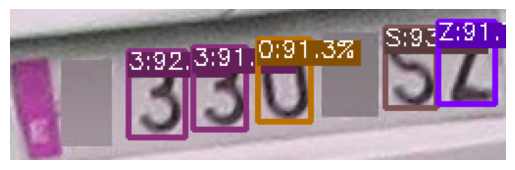

In [ ]:
image_path = "/home/sunandad/Downloads/HW2/HW2/code/character-detection-datasets/data/test_00038_1.jpg"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")

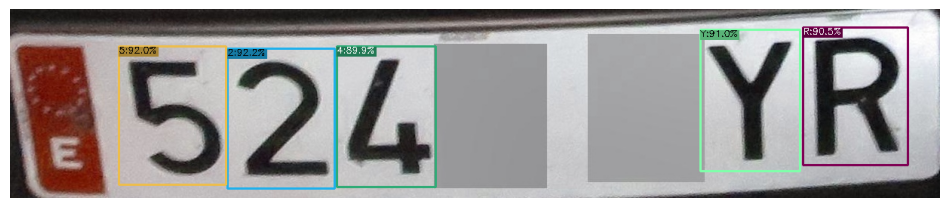

In [ ]:
image_path = "/home/sunandad/Downloads/HW2/HW2/code/character-detection-datasets/data/test_00384_0.jpg"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

plt.figure(figsize=(12,12))
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")

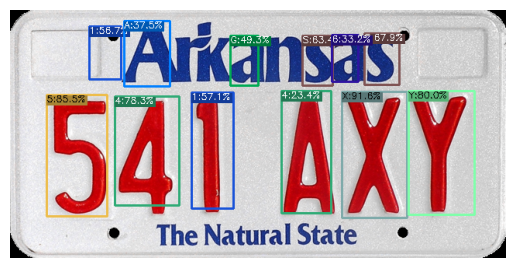

In [ ]:
image_path = "/home/sunandad/Downloads/HW2/HW2/code/New Set/c1.png"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, .2)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")

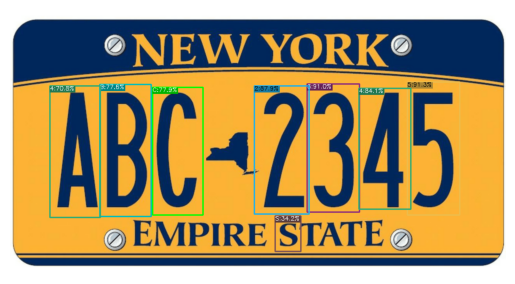

In [ ]:
image_path = "/home/sunandad/Downloads/HW2/HW2/code/New Set/c9.webp"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, .3)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")

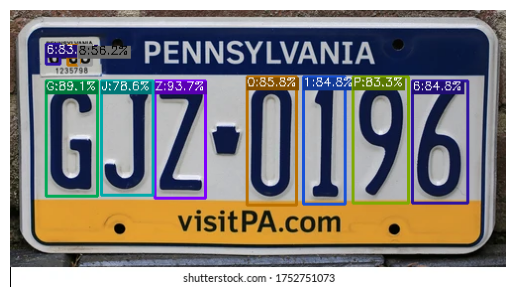

In [ ]:
image_path = "/home/sunandad/Downloads/HW2/HW2/code/New Set/c10.webp"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, .5)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")